In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa #Para conexión a BD, requerido para usar pd.read_sql()
import urllib #Para formatear string de conexión
import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl
from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage
import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#url = "C:/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/"
#url='/mnt/c/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/'
#url = 'C:/Users/USER/OneDrive - DCCP/Documents/comunicaciones dpto/Reporte_cifras_MP_automatizado'
url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos

#Funcion para poner puntos separadores de miles
def itanum(x):
    return format(int(round(x)),',d').replace(",",".")

#Funcion para poner coma a decimales
#Pensado para generador de Nov-2023
def flonum(x):
    return format(x,',').replace(".",",")    

#Transforma una tasa en un string de porcentage con un decimal
def pctaje(x):
    #format(x,',').replace(".",",")
    #return str(round(x, 1))+'%'
    x = str(round(x, 1))+'%'
    return format(x,'s').replace(".",",")

def cambiar_fuente_global(documento, nueva_fuente):
    # Crear un nuevo estilo personalizado
    nuevo_estilo = documento.styles.add_style('NuevoEstilo', 1)

    # Establecer la nueva fuente en el estilo
    nuevo_estilo.font.name = nueva_fuente

    # Aplicar el nuevo estilo a todos los párrafos en el documento
    for p in documento.paragraphs:
        p.style = nuevo_estilo

#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')

AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 8

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
###

In [5]:
########################################
### Query con datos a nivel regional ###
########################################

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])




#cursor.execute("EXEC "+upside_sproc)
##Se utiliza el wildcard ? para agregar los parámetros
QueryReg = pd.read_sql(con = conn_DW,  sql = '''
    ;with temp as (
	SELECT TPO.YEAR 'Ano'
         , tpo.Month as 'Mes'
        , LOC.Region
       , (CASE oc1.porisintegrated WHEN 3 THEN 'CAg'
                else (case  OC1.IDProcedenciaOC
                                WHEN 703 THEN 'Convenio Marco'
                                WHEN 701 THEN 'Licitación Pública'
                                WHEN 1401 THEN 'Licitación Pública'
                                WHEN 702 THEN 'Licitación Privada'
                                ELSE 'Trato Directo' END)END) 'ProcedenciaOC'
       , I.NombreInstitucion
       ,case when a.idTamano is not null then cast(a.idTamano as nvarchar)
				 else isnull(b.tamanonombre,'SinDato') end tamano0
       ,  COUNT(DISTINCT P.RUTSucursal)      'CantProveedores'
       , COUNT(DISTINCT OC1.CodigoOC) 'CantOC'    
       , SUM(OC1.MontoUSD+OC1.ImpuestoUSD) 'MONTOUSD'
       , SUM(OC1.MontoCLP+OC1.ImpuestoCLP) 'MONTOCLP'
       , SUM(OC1.MontoCLF+OC1.ImpuestoCLF) 'MONTOCLF'

 

    FROM DM_Transaccional..THOrdenesCompra  AS OC1
    inner JOIN DM_Transaccional..DimTiempo AS TPO                     ON OC1.IDFechaEnvioOC=TPO.DateKey
    inner JOIN DM_Transaccional..DimProcedenciaOC AS PRO   ON PRO.IDProcedenciaOC = OC1.IDProcedenciaOC
    left JOIN DM_Transaccional..DimComprador AS C        ON OC1.IDUnidaddeCompra = C.IDUnidaddeCompra
    left JOIN DM_Transaccional..DimProveedor AS P        ON P.IDSucursal=OC1.IDSucursal
	left join [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=p.entCode and AñoTributario=2021
    left join Estudios.dbo.TamanoProveedorNuevos20230802 b on p.entcode=b.entCode
    LEFT JOIN  DM_Transaccional..DimTamanoProveedor AS TP ON TP.IdTamano=a.IdTamano
    left JOIN DM_Transaccional..DimInstitucion AS I      ON C.entCode = I.entCode
    left JOIN DM_Transaccional..DimSector AS S           ON S.IdSector = I.IdSector
    left JOIN DM_Transaccional..DimLocalidad as loc      ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad

    --Dado que existe comparacion anual, debe tomarse con año 1 y año -1
    WHERE   TPO.YEAR in(2023,2022)
            AND TPO.MONTH >= 1 AND TPO.MONTH <= 8
    GROUP BY TPO.YEAR,TPO.MONTH, 
	case when a.idTamano is not null then cast(a.idTamano as nvarchar)
				 else isnull(b.tamanonombre,'SinDato') end ,
				 I.NombreInstitucion,  LOC.Region,
           (CASE OC1.porisintegrated WHEN 3 THEN 'CAg'
                else (case  OC1.IDProcedenciaOC
                                WHEN 703 THEN 'Convenio Marco'
                                WHEN 701 THEN 'Licitación Pública'
                                WHEN 1401 THEN 'Licitación Pública'
                                WHEN 702 THEN 'Licitación Privada'
                                ELSE 'Trato Directo' END)END)
    )
	Select 		Ano

        , Mes
        , Region
       ,  ProcedenciaOC
       , NombreInstitucion
	   ,case  when tamano0 in ('PYME','Microempresa','2','3','4') then 'MiPyme'
				when tamano0 in ('Grande','1') then 'Grande'
				when tamano0  in ('5','Extranjera','SinDato') then 'SinDato' 
					end Tamano,
			sum(MONTOUSD) MONTOUSD,
			sum(MONTOCLF) MONTOCLF,
			sum(MONTOCLP) MONTOCLP,
			sum(CantOC) CantOC,
			sum(CantProveedores)      'CantProveedores'
	from temp
	group by 	Ano   
        , Mes
        , Region
       ,  ProcedenciaOC
       , NombreInstitucion
	  , case  when tamano0 in ('PYME','Microempresa','2','3','4') then 'MiPyme'
				when tamano0 in ('Grande','1') then 'Grande'
				when tamano0  in ('5','Extranjera','SinDato') then 'SinDato' 
					end
    ''')

print(QueryReg)
print('------------------------------------------------------------------------------------------------------------')

#sys.exit()

         Ano  Mes       Region  ProcedenciaOC  \
0       2022    1  Antofagasta            CAg   
1       2022    1  Antofagasta            CAg   
2       2022    1  Antofagasta            CAg   
3       2022    1  Antofagasta            CAg   
4       2022    1  Antofagasta            CAg   
...      ...  ...          ...            ...   
164252  2023    8   Valparaíso  Trato Directo   
164253  2023    8   Valparaíso  Trato Directo   
164254  2023    8   Valparaíso  Trato Directo   
164255  2023    8   Valparaíso  Trato Directo   
164256  2023    8   Valparaíso  Trato Directo   

                                        NombreInstitucion   Tamano  \
0       CENTRO DE FORMACION TECNICA DE LA REGION DE AN...   Grande   
1       CENTRO DE FORMACION TECNICA DE LA REGION DE AN...   MiPyme   
2                             CENTRO ONCOLOGICO DEL NORTE   Grande   
3                             CENTRO ONCOLOGICO DEL NORTE   MiPyme   
4           Corporación Administrativa del Poder Judicial   G

In [6]:
#####################################
### Query top 3 rubros por region ###
#####################################

##Parametros de fecha Query rubro
FechaQRubro = FechaQ.drop(FechaQ.index[1])


QueryRegRubro = pd.read_sql(con = conn_DW,  sql = 
''' 
select * 
 from( select
LOC.Region
,rubro.RubroN1
,SUM(OCL.MontoUSD) 'MONTOUSD'
, SUM(OCL.MontoCLP) 'MONTOCLP'
, SUM(OCL.MontoCLF) 'MONTOCLF'
, Rank() over (Partition BY LOC.Region ORDER BY  SUM(OCL.MontoUSD) DESC ) AS Rank
	FROM  
	DM_Transaccional..THOrdenesCompra AS OC     
	LEFT JOIN DM_Transaccional..DimTiempo AS TPO                     ON OC.IDFechaEnvioOC=TPO.DateKey 
	LEFT JOIN DM_Transaccional..DimProcedenciaOC AS PRO   ON PRO.IDProcedenciaOC = OC.IDProcedenciaOC
	INNER JOIN DM_Transaccional..DimComprador AS C        ON OC.IDUnidaddeCompra = C.IDUnidaddeCompra
	INNER JOIN DM_Transaccional..DimProveedor AS P        ON P.IDSucursal=OC.IDSucursal
	--LEFT JOIN  DM_Transaccional..DimTamanoProveedor AS TP ON TP.IdTamano=P.IdTamano
	INNER JOIN DM_Transaccional..DimInstitucion AS I      ON C.entCode = I.entCode   
	INNER JOIN DM_Transaccional..DimSector AS S           ON S.IdSector = I.IdSector
	INNER JOIN DM_Transaccional..DimLocalidad as loc	  ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad
	LEFT JOIN  DM_Transaccional..THOrdenesCompraLinea OCL ON OCL.porID=OC.porID
	LEFT JOIN DM_Transaccional..DimProducto produc ON produc.IDProducto=OCL.IDProducto 
	LEFT JOIN DM_Transaccional..DimRubro rubro on rubro.IdRubro=produc.IdRubro
	--Dado que existe comparacion anual, debe tomarse con año 1 y año -1
	WHERE   TPO.YEAR = 2023
    	AND  TPO.month between 1 and 8
	GROUP BY LOC.Region,rubro.RubroN1
			)rs WHERE Rank <= 3 ORDER BY Region ASC, Rank ASC
                                               ''') 


#sys.exit()

##Cambio formato df
##QueryRegRubro['Region'] = str(QueryRegRubro['Region'])

In [7]:
##############################################################
### Query con datos a nivel nacional. Solo no tiene Region ###
##############################################################

print('Datos a nivel nacional. Inputs:\n')
print(FechaQ)
print()

QueryTotal = pd.read_sql(con = conn_DW, sql = '''
;with temp as (
    SELECT TPO.YEAR 'Ano' --TPO.MONTHNAME 'Mes'
    , tpo.Month as 'Mes'
    , (CASE oc1.porisintegrated WHEN 3 THEN 'CAg'
            else (case  OC1.IDProcedenciaOC
                            WHEN 703 THEN 'Convenio Marco'
                                WHEN 701 THEN 'Licitación Pública'
                                WHEN 1401 THEN 'Licitación Pública'
                                WHEN 702 THEN 'Licitación Privada'
                                ELSE 'Trato Directo' END)END) 'ProcedenciaOC'
	   ,I.NombreInstitucion
       ,case when a.idTamano is not null then cast(a.idTamano as nvarchar)
                    else isnull(b.tamanonombre,'SinDato') end tamano0
       , COUNT(DISTINCT P.RUTSucursal)      'CantProveedores'
       , COUNT(DISTINCT OC1.CodigoOC) 'CantOC'    
       , SUM(OC1.MontoUSD+OC1.ImpuestoUSD) 'MONTOUSD'
       , SUM(OC1.MontoCLP+OC1.ImpuestoCLP) 'MONTOCLP'
       , SUM(OC1.MontoCLF+OC1.ImpuestoCLF) 'MONTOCLF'

    FROM DM_Transaccional..THOrdenesCompra  AS OC1
    inner JOIN DM_Transaccional..DimTiempo AS TPO                     ON OC1.IDFechaEnvioOC=TPO.DateKey
    inner JOIN DM_Transaccional..DimProcedenciaOC AS PRO   ON PRO.IDProcedenciaOC = OC1.IDProcedenciaOC
    left JOIN DM_Transaccional..DimComprador AS C        ON OC1.IDUnidaddeCompra = C.IDUnidaddeCompra
    left JOIN DM_Transaccional..DimProveedor AS P        ON P.IDSucursal=OC1.IDSucursal
    left join [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=p.entCode and AñoTributario=2021
    left join Estudios.dbo.TamanoProveedorNuevos20230802 b on p.entcode=b.entCode
    LEFT JOIN  DM_Transaccional..DimTamanoProveedor AS TP ON TP.IdTamano=a.IdTamano
    left JOIN DM_Transaccional..DimInstitucion AS I      ON C.entCode = I.entCode
    left JOIN DM_Transaccional..DimSector AS S           ON S.IdSector = I.IdSector
    left JOIN DM_Transaccional..DimLocalidad as loc      ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad
    
	--Dado que existe comparacion anual, debe tomarse con año 1 y año -1
    WHERE   TPO.YEAR in(2023,2022)
            AND TPO.MONTH >= 1 AND TPO.MONTH <= 8
    GROUP BY TPO.YEAR,TPO.MONTH, TP.Tamano,
	case when a.idTamano is not null then cast(a.idTamano as nvarchar)
				 else isnull(b.tamanonombre,'SinDato') end ,
				 I.NombreInstitucion,
           (CASE oc1.porisintegrated WHEN 3 THEN 'CAg'
                else (case  OC1.IDProcedenciaOC
                                WHEN 703 THEN 'Convenio Marco'
                                WHEN 701 THEN 'Licitación Pública'
                                WHEN 1401 THEN 'Licitación Pública'
                                WHEN 702 THEN 'Licitación Privada'
                                ELSE 'Trato Directo' END)END)
   )
   Select       Ano

        , Mes
       ,  ProcedenciaOC
       , NombreInstitucion
       ,case  when tamano0 in ('PYME','Microempresa','2','3','4') then 'MiPyme'
                when tamano0 in ('Grande','1') then 'Grande'
                when tamano0  in ('5','Extranjera','SinDato') then 'SinDato'
                    end Tamano,
            sum(MONTOUSD) MONTOUSD,
            sum(MONTOCLF) MONTOCLF,
            sum(MONTOCLP) MONTOCLP,
            sum(CantOC) CantOC,
            sum(CantProveedores)      'CantProveedores'
    from temp
    group by    Ano
        , Mes
       ,  ProcedenciaOC
       , NombreInstitucion
      , case  when tamano0 in ('PYME','Microempresa','2','3','4') then 'MiPyme'
                when tamano0 in ('Grande','1') then 'Grande'
                when tamano0  in ('5','Extranjera','SinDato') then 'SinDato'
                    end
        ''')

print(QueryTotal)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#Se requiere una query aparte para calcular el total de proveedores. Se quita mes y procedencia

Datos a nivel nacional. Inputs:

0    2023
1    2022
2       1
3       8
dtype: int64

         Ano  Mes       ProcedenciaOC  \
0       2022    4                 CAg   
1       2023    8       Trato Directo   
2       2023    1       Trato Directo   
3       2022    4  Licitación Pública   
4       2023    2      Convenio Marco   
...      ...  ...                 ...   
120036  2022    5                 CAg   
120037  2023    8                 CAg   
120038  2023    3  Licitación Pública   
120039  2022    6       Trato Directo   
120040  2022    6                 CAg   

                                        NombreInstitucion   Tamano  \
0                                I MUNICIPALIDAD DE PAINE  SinDato   
1                         I MUNICIPALIDAD DE SAN FERNANDO   Grande   
2                            Comisión Nacional de Energía   Grande   
3                             MOP - Dirección de Vialidad   Grande   
4       SUBSECRETARIA DEL MINISTERIO DE EDUCACION PUBLICA   Grande   


In [8]:
# =============================================================================
# Query Top Sectores Regionales
# =============================================================================

# Para obtener Totales año actual y año Anterior

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QSecReg = pd.read_sql(con = conn_DW,  sql = '''
SELECT 	loc.region,
		Sector,
        SUM(OC.MontoUSD+OC.ImpuestoUSD) 'Monto_Bruto_USD',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'Monto_Bruto_CLP',
		count(oc.porid) CantOC
		   

FROM DM_Transaccional..THOrdenesCompra AS OC     
	inner JOIN DM_Transaccional..DimTiempo AS TPO			ON OC.IDFechaEnvioOC=TPO.DateKey
	left JOIN DM_Transaccional..DimComprador AS C			ON OC.IDUnidaddeCompra = C.IDUnidaddeCompra 
	left JOIN DM_Transaccional..DimInstitucion AS I			ON C.entCode = I.entCode   
	LEFT JOIN DM_Transaccional..DimSector AS S				ON S.IdSector = I.IdSector
	left JOIN DM_Transaccional..DimLocalidad as loc			ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad

WHERE   TPO.YEAR in (2023) 
	AND	TPO.MONTH<=8
GROUP BY  Region,
	SECTOR
order by Region,
	Monto_Bruto_USD DESC, 
	SECTOR
''')
print(QSecReg)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

          region                       Sector  Monto_Bruto_USD  \
0    Antofagasta               Obras Públicas     1.031789e+08   
1    Antofagasta              Municipalidades     8.316064e+07   
2    Antofagasta                        Salud     5.929691e+07   
3    Antofagasta  Gob. Central, Universidades     2.467005e+07   
4    Antofagasta                         FFAA     5.898949e+06   
..           ...                          ...              ...   
107   Valparaíso  Gob. Central, Universidades     1.726992e+08   
108   Valparaíso               Obras Públicas     1.071783e+08   
109   Valparaíso                         FFAA     9.032560e+07   
110   Valparaíso       Legislativo y judicial     1.289679e+07   
111   Valparaíso                        Otros     1.132237e+07   

     Monto_Bruto_CLP  CantOC  
0       8.404418e+10     728  
1       6.798118e+10    6315  
2       4.828826e+10   10284  
3

In [9]:
# =============================================================================
# Query CA por región periodo actual y anterior
# =============================================================================

# Para obtener Totales año actual y año Anterior

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QCAReg = pd.read_sql(con = conn_DW,  sql = '''
DECLARE @ANO Int
DECLARE @ANOM1 Int
SET @ANO = 2023
SET @ANOM1 = @ANO - 1

SELECT	@ANO 'Ano',
		loc.Region 'Region',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP_CAg'	    ,
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD_CAg'	    ,
		count(distinct porid) 'CantOC_CAg'
FROM	dm_transaccional..THOrdenesCompra AS OC     
		inner JOIN dm_transaccional..DimTiempo AS TPO		ON OC.IDFechaEnvioOC=TPO.DateKey 
		inner join [dm_transaccional].dbo.DimComprador c	on c.IDUnidaddeCompra=oc.IDUnidaddeCompra
		inner join [dm_transaccional]..diminstitucion i		on i.entcode=c.entCode 
		inner JOIN dm_transaccional..DimLocalidad as loc	ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad
WHERE   TPO.YEAR in (@ANO) 
		AND    TPO.MONTH<=8-- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		and oc.porIsIntegrated=3
group by loc.Region

UNION

SELECT	@ANOM1 'Ano',
		loc.Region collate Modern_Spanish_CI_AS 'Region',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP_CAg'	    ,
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD_CAg'	    ,
		count(distinct porid) 'CantOC_CAg'
FROM	[10.34.71.227].DM_Transaccional_2022.DBO.THOrdenesCompra AS OC     
		inner JOIN [10.34.71.227].DM_Transaccional_2022.DBO.DimTiempo AS TPO		ON OC.IDFechaEnvioOC=TPO.DateKey 
		inner join [10.34.71.227].DM_Transaccional_2022.dbo.DimComprador c			on c.IDUnidaddeCompra=oc.IDUnidaddeCompra 
		inner join [10.34.71.227].DM_Transaccional_2022.DBO.diminstitucion i		on i.entcode=c.entCode 
		inner JOIN [10.34.71.227].DM_Transaccional_2022.DBO.DimLocalidad as loc		ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad
WHERE   TPO.YEAR in (@ANOM1) 
		AND    TPO.MONTH<=8-- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		and oc.porIsIntegrated=3
group by loc.Region              

ORDER BY 'Region',
		'Ano' DESC
''')
print(QCAReg)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

     Ano                     Region  MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
0   2023                Antofagasta  6.970619e+09  8.575486e+06        9820
1   2022                Antofagasta  6.260722e+09  7.310428e+06        9067
2   2023                  Araucanía  2.542775e+10  3.127240e+07       34775
3   2022                  Araucanía  1.963787e+10  2.290707e+07       28948
4   2023         Arica y Parinacota  5.747260e+09  7.063838e+06        8215
5   2022         Arica y Parinacota  4.054672e+09  4.719849e+06        6033
6   2023                    Atacama  7.458927e+09  9.179058e+06       11767
7   2022                    Atacama  5.221718e+09  6.085403e+06        9150
8   2023                      Aysén  6.175175e+09  7.589837e+06        9467
9   2022                      Aysén  4.820661e+09  5.636189e+06        8162
10  2023                    Bío-Bío  2.879694e+10  3.543688e+07       42986
11  20

In [10]:
########################
### Total  Proveedor ###
########################

FechaTotProv =  FechaQ.drop(FechaQ.index[1])
print('Tamaño proveedor (nacional). Inputs:\n')
print(FechaTotProv)
print()

QueryTotalProv = pd.read_sql(con = conn_DW,  sql = 
        '''SELECT       
				case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end Tamano

			,SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD'
		   , SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF'
		   ,SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP'
			  ,count(distinct oc.porid) CantOC
               ,COUNT(DISTINCT P.RUTSucursal) 'CantProveedores'
			--  into #aux1
     FROM  
    DM_Transaccional..THOrdenesCompra AS OC     
    inner JOIN DM_Transaccional..DimTiempo AS TPO                     ON OC.IDFechaEnvioOC=TPO.DateKey 
	inner join [DM_Transaccional].[dbo].[dimproveedor] p on p.orgCode=oc.IDSucursal
    left join   [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=p.entCode and AñoTributario=2021
    left join Estudios.dbo.TamanoProveedorNuevos20230809 b on p.entcode=b.entCode
    WHERE   TPO.YEAR in (2023) and TPO.MONTH >= 1 AND TPO.MONTH <= 8
	group by case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end    
                             ''')
print(QueryTotalProv)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()

Tamaño proveedor (nacional). Inputs:

0    2023
2       1
3       8
dtype: int64

   Tamano      MONTOUSD      MONTOCLF      MONTOCLP  CantOC  CantProveedores
0  Grande  6.787422e+09  1.541876e+08  5.511828e+12  548318             2557
1  Mipyme  4.208748e+09  9.571242e+07  3.423301e+12  732800            63542

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [11]:
##################################
### Query top 10 OC por region ###
##################################

FechaQTop10 = FechaQ.drop(FechaQ.index[1])
print('Top 10 OC por region','Inputs:\n')
print(FechaQTop10)
print()

QTop10 = pd.read_sql(con = conn_DW,  sql = ''' 
SELECT *
    FROM (
        SELECT 
                case 
					when a.idTamano is not null then 
						case a.idTamano when 1 then 'Grande'
						else 'Mipyme' end
				else 
					case isnull(b.Tamano,5) 
						when 1 then 'Grande'
						else 'Mipyme' end end Tamano,
    DM_Transaccional.dbo.DimInstitucion.NombreInstitucion,
    DM_Transaccional.dbo.DimComprador.NombreUnidaddeCompra,
    DM_Transaccional.dbo.DimLocalidad.Region,
    DM_Transaccional.dbo.DimProveedor.NombreSucursal,
    --DM_Transaccional.dbo.DimTamanoProveedor.Tamano,
    DM_Transaccional.dbo.THOrdenesCompra.CodigoOC,
    DM_Transaccional.dbo.THOrdenesCompra.NombreOC,
    DM_Transaccional.dbo.THOportunidadesNegocio.NombreAdq as NombreLic,
    ISNULL(DM_Transaccional.dbo.THOportunidadesNegocio.NombreAdq, DM_Transaccional.dbo.THOrdenesCompra.NombreOC) as MotivoCompra,
    round(DM_Transaccional.dbo.THOrdenesCompra.MontoUSD + DM_Transaccional.dbo.THOrdenesCompra.ImpuestoUSD,0) USD_BRUTO,
    DM_Transaccional.dbo.THOrdenesCompra.MontoCLP + DM_Transaccional.dbo.THOrdenesCompra.ImpuestoCLP PESOS_BRUTO, Rank()
          over (Partition BY DM_Transaccional.dbo.DimLocalidad.Region
                ORDER BY DM_Transaccional.dbo.THOrdenesCompra.MontoUSD DESC ) AS Rank
                FROM DM_Transaccional.dbo.DimInstitucion INNER JOIN
             DM_Transaccional.dbo.DimComprador ON DM_Transaccional.dbo.DimInstitucion.entCode = DM_Transaccional.dbo.DimComprador.entCode INNER JOIN
             DM_Transaccional.dbo.DimLocalidad ON DM_Transaccional.dbo.DimComprador.IDLocalidadUnidaddeCompra = DM_Transaccional.dbo.DimLocalidad.IDLocalidad INNER JOIN
             DM_Transaccional.dbo.THOrdenesCompra ON DM_Transaccional.dbo.DimComprador.IDUnidaddeCompra = DM_Transaccional.dbo.THOrdenesCompra.IDUnidaddeCompra INNER JOIN
             DM_Transaccional.dbo.DimProveedor ON DM_Transaccional.dbo.DimProveedor.IDSucursal = DM_Transaccional.dbo.THOrdenesCompra.IDSucursal INNER JOIN
             --DM_Transaccional.dbo.DimTamanoProveedor ON DM_Transaccional.dbo.DimTamanoProveedor.IdTamano = DM_Transaccional.dbo.DimProveedor.IdTamano INNER JOIN
             DM_Transaccional.dbo.DimTiempo ON DM_Transaccional.dbo.DimTiempo.DateKey =  DM_Transaccional.dbo.THOrdenesCompra.IDFechaEnvioOC LEFT JOIN
             DM_Transaccional.dbo.THOportunidadesNegocio ON DM_Transaccional.dbo.THOportunidadesNegocio.rbhCode = DM_Transaccional.dbo.THOrdenesCompra.rbhCode
             left join   [DM_Transaccional].[dbo].[THTamanoProveedor] a on a.entcode=[DM_Transaccional].[dbo].[dimproveedor].entCode and AñoTributario=2021
             left join Estudios.dbo.TamanoProveedorNuevos20230809 b on [DM_Transaccional].[dbo].[dimproveedor].entcode=b.entCode
          where DM_Transaccional.dbo.dimtiempo.Year = 2023
             and DM_Transaccional.dbo.dimtiempo.month between 1 and 8
        ) rs WHERE Rank <= 3 ORDER BY Region ASC, Rank ASC
                ''')


print(QTop10)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()


Top 10 OC por region Inputs:

0    2023
2       1
3       8
dtype: int64

    Tamano                                  NombreInstitucion  \
0   Grande      SERVICIO DE VIVIENDA Y URBANIZACION II REGION   
1   Grande      SERVICIO DE VIVIENDA Y URBANIZACION II REGION   
2   Grande                        MOP - Dirección de Vialidad   
3   Grande  MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...   
4   Grande                        MOP - Dirección de Vialidad   
5   Grande                        MOP - Dirección de Vialidad   
6   Grande                           I MUNICIPALIDAD DE ARICA   
7   Mipyme                         SERVICIO DE SALUD DE ARICA   
8   Grande                           I MUNICIPALIDAD DE ARICA   
9   Grande                          Servicio de Salud Atacama   
10  Grande                          Servicio de Salud Atacama   
11  Grande  MINISTERIO DE OBRAS PUBLICAS DIREC CION GRAL D...   
12  Grande                        MOP - Dirección de Vialidad   
13  Grande      

In [12]:
###########################################################################
### Query para obtener número total de proveedores que participan en MP ###
###########################################################################

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QProvTrans = pd.read_sql(con = conn_AQ,  sql = '''
SELECT DISTINCT C.entCode AS Transan
FROM         
DCCPProcurement..prcPOHeader A with(nolock)INNER JOIN
DCCPPlatform..gblOrganization B with(nolock) ON A.porSellerOrganization = B.orgCode INNER JOIN
DCCPPlatform..gblEnterprise C with(nolock) ON B.orgEnterprise = C.entCode
WHERE     (A.porBuyerStatus IN (4, 5, 6, 7, 12)) 
AND year(A.porSendDate) =  2023 
and (month(A.porSendDate)>=1 AND month(A.porSendDate)<= 8 )
''')
print(QProvTrans)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()

#FechaProv2=pd.concat([FechaProv],ignore_index=True) #,FechaProv,FechaProv,FechaProv], ignore_index=True) # For conn_AQ connection using
#print()
#
#vec2=[] # vector de parametros para conn_AQ_pyodbc
#for k in range(1):
#    vec2.append(vec[0])
#    vec2.append(vec[1])
#    vec2.append(vec[2])
#
#
#QProv = pd.read_sql(con = conn_AQ, params= FechaProv2, sql = '''
#
#    /*Proveedores involucrados en una OC*/
#    SELECT DISTINCT C.entCode AS Transan
#    FROM         
#    DCCPProcurement..prcPOHeader A with(nolock)INNER JOIN
#    DCCPPlatform..gblOrganization B with(nolock) ON A.porSellerOrganization = B.orgCode INNER JOIN
#    DCCPPlatform..gblEnterprise C with(nolock) ON B.orgEnterprise = C.entCode
#    WHERE     (A.porBuyerStatus IN (4, 5, 6, 7, 12)) 
#    AND year(A.porSendDate) =  ? 
#    and ( month(A.porSendDate)>= ? AND month(A.porSendDate)<= ? )
#    
#    UNION 
#    
#    /*Proveedores que han participado emitiendo una oferta*/
#    
#    SELECT DISTINCT C.orgEnterprise as Transan
#    FROM         
#    DCCPProcurement..prcBIDQuote A with(nolock)INNER JOIN
#    DCCPProcurement..prcRFBHeader B with(nolock) ON A.bidRFBCode = B.rbhCode INNER JOIN
#    DCCPPlatform..gblOrganization C with(nolock) ON A.bidOrganization = C.orgCode
#    WHERE     (A.bidDocumentStatus IN (3, 4, 5)) 
#    AND year(A.bidEconomicIssueDate) = ? 
#    and (month(A.bidEconomicIssueDate)>= ? AND month(A.bidEconomicIssueDate)<= ? )
#
#    UNION
#    
#    /*Proveedores a los que se les ha solicitado una cotización*/
#    
#    SELECT  DISTINCT (B.orgEnterprise) AS Transan     
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A
#      INNER JOIN DCCPPlatform..gblOrganization B ON
#      A.proveedorRut=B.orgTaxID INNER JOIN
#      DCCPProcurement..prcPOHeader C ON
#      A.porId = C.porID
#      WHERE year(C.porSendDate) = ? 
#    and (month(C.porSendDate)>= ? AND month(C.porSendDate)<= ?)
#    
#    UNION
#    /*MÁS LOS RUT NO REGISTRADOS EN MERCADO PÚBLICO Y QUE SON DEL PERÍODO DE REFERENCIA*/
#    
#    SELECT  
#    DISTINCT A.proveedorRut   
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A INNER JOIN
#       DCCPProcurement..prcPOHeader C ON
#      A.porId = C.porID
#      WHERE A.proveedorRut NOT IN (
#    SELECT  
#    DISTINCT A.proveedorRut     
#      FROM [DCCPProcurement].[dbo].[prcPOCotizacion] A
#      INNER  JOIN DCCPPlatform..gblOrganization B ON
#      A.proveedorRut=B.orgTaxID) AND 
#      year(C.porSendDate) = ? and 
#      (month(C.porSendDate)>= ? AND month(C.porSendDate)<= ?)''')
#
##Query total proveedores que participaron (No solo tienen OC asociada) Pedir a Javier
#print(QProv)
#print()
#print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
#print()
##sys.exit()


####  ESTA ES EL OUTPUT DE LA QUERY ANTERIOR PERO YA EJECUTADA EN SQL SERVER, PORQUE LA ANTERIOR DEMORA MUCHO ####
QProv=pd.read_sql(con=conn_AQ, sql='''
    SELECT *
    FROM estudios.dbo.ProveedoresTransando20230811
    ''')
print(QProv)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()
#sys.exit()




Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

       Transan
0       100235
1       100534
2      1008780
3      1010091
4      1010159
...        ...
65941    96510
65942    98678
65943    99078
65944    99374
65945    99977

[65946 rows x 1 columns]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------

        Transan
0       1180980
1       1210813
2        121833
3       1224596
4       1244685
...         ...
130394  1842696
130395  1773595
130396   200564
130397  1650575
130398  1756051

[130399 rows x 1 columns]

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [13]:
# =============================================================================
# Query Totales Nacionales
# =============================================================================

# Para obtener Totales año actual y año Anterior

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QTotNacDif = pd.read_sql(con = conn_DW,  sql = '''
DECLARE @ANO Int
DECLARE @ANOM1 Int
SET @ANO = 2023
SET @ANOM1 = @ANO - 1

SELECT @ANO 'ANO', 
		SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF', 
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP', 
		COUNT(OC.MontoCLF) 'CANTIDADOC'	
FROM DM_Transaccional..THOrdenesCompra AS OC LEFT JOIN 
		DM_Transaccional..DimTiempo AS TPO	ON OC.IDFechaEnvioOC=TPO.DateKey 
WHERE   TPO.YEAR in (@ANO) -- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		AND tpo.Month <=8

UNION

SELECT @ANOM1 'ANO', 
		SUM(OC.MontoCLF+OC.ImpuestoCLF) 'MONTOCLF', 
		SUM(OC.MontoUSD+OC.ImpuestoUSD) 'MONTOUSD',
		SUM(OC.MontoCLP+OC.ImpuestoCLP) 'MONTOCLP', 
		COUNT(OC.MontoCLF) 'CANTIDADOC'	
FROM [10.34.71.227].DM_Transaccional_2022.dbo.THOrdenesCompra AS OC LEFT JOIN 
		[10.34.71.227].DM_Transaccional_2022.dbo.DimTiempo AS TPO    ON OC.IDFechaEnvioOC=TPO.DateKey 
WHERE   TPO.YEAR in (@ANOM1) -- and (oc.OCEXCEPCIONAL=0 or oc.OCEXCEPCIONAL is null ) 
		AND tpo.Month <=8

ORDER BY ANO DESC
''')
print(QTotNacDif)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

    ANO      MONTOCLF      MONTOUSD      MONTOCLP  CANTIDADOC
0  2023  2.499000e+08  1.099617e+10  8.935129e+12     1281118
1  2022  2.666536e+08  1.018848e+10  8.589468e+12     1116428

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [14]:
# =============================================================================
# Query Top OOPP Nacionales
# =============================================================================

# # Top OOPP por transacción nacional

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QOPNac = pd.read_sql(con = conn_DW,  sql = '''
SELECT TOP 3
i.entCode,
NombreInstitucion Institución,
(sum(MontoUSD + ImpuestoUSD)) Monto_Bruto_USD,
(sum(Montoclp + Impuestoclp)) Monto_Bruto_CLP

FROM [DM_Transaccional].[dbo].[THOrdenesCompra] oc inner join
[DM_Transaccional]..DimTiempo t on t.DateKey=oc.IDFechaEnvioOC left join
[DM_Transaccional].dbo.DimComprador c on c.IDUnidaddeCompra=oc.IDUnidaddeCompra left join
[DM_Transaccional].dbo.THOportunidadesNegocio opn on opn.rbhCode=oc.rbhCode left join
[DM_Transaccional]..diminstitucion i on i.entcode=c.entCode 
left JOIN DM_Transaccional..DimLocalidad as loc	  ON C.IDLocalidadUnidaddeCompra =  LOC.IDLocalidad
where
t.Year in (2023)
AND T.MONTH <=8
group by
i.entcode, NombreInstitucion
order by sum(MontoUSD + ImpuestoUSD) desc, entCode
''')
# se pede modificar el rango
print(QOPNac)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

   entCode                                     Institución  Monto_Bruto_USD  \
0     6957  Central de Abastecimiento S.N.S.S. -  CENABAST     1.383617e+09   
1     7248                     MOP - Dirección de Vialidad     7.773507e+08   
2     7002        JUNTA NACIONAL DE AUXILIO ESCOLAR Y BECA     5.785055e+08   

   Monto_Bruto_CLP  
0     1.121012e+12  
1     6.291114e+11  
2     4.674095e+11  

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [15]:
# =============================================================================
# Query Top Sectores Nacionales
# =============================================================================

# # Top OOPP por transacción nacional

##Calculando fecha para query dinamica
FechaProv =  FechaQ.drop(FechaQ.index[1])
##Proveedores solo transando
print('Proveedores transando en MP.','Inputs:\n')
print(FechaProv)
print()
#vec=['2023','1','6'] ### vector de parametros para usar con con=conn_AQ_pyodbc

QSecNac = pd.read_sql(con = conn_DW,  sql = '''
SELECT 	Sector
        , SUM(OC.MontoUSD+OC.ImpuestoUSD) 'Monto_Bruto_USD'
		, SUM(OC.MontoCLP+OC.ImpuestoCLP) 'Monto_Bruto_CLP'
		, count(oc.porid) CantOC
		   
FROM  DM_Transaccional..THOrdenesCompra AS OC     
	inner JOIN DM_Transaccional..DimTiempo AS TPO			ON OC.IDFechaEnvioOC=TPO.DateKey
	left JOIN DM_Transaccional..DimComprador AS C			ON OC.IDUnidaddeCompra = C.IDUnidaddeCompra 
	left JOIN DM_Transaccional..DimInstitucion AS I			ON C.entCode = I.entCode   
	LEFT JOIN DM_Transaccional..DimSector AS S				ON S.IdSector = I.IdSector

WHERE   TPO.YEAR in (2023) 
	AND	TPO.MONTH<=8

GROUP BY  SECTOR

order by Monto_Bruto_USD DESC
''')
# se pede modificar el rango
print(QSecNac)
print()
print('--------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print()

Proveedores transando en MP. Inputs:

0    2023
2       1
3       8
dtype: int64

                        Sector  Monto_Bruto_USD  Monto_Bruto_CLP  CantOC
0                        Salud     3.812129e+09     3.095413e+12  497283
1              Municipalidades     2.614740e+09     2.126995e+12  433852
2  Gob. Central, Universidades     2.378538e+09     1.932940e+12  195320
3               Obras Públicas     1.401478e+09     1.137131e+12   19353
4                         FFAA     6.023537e+08     4.906778e+11  102411
5                        Otros     1.356681e+08     1.103469e+11   25202
6       Legislativo y judicial     5.126354e+07     4.162516e+10    7697

--------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [16]:
# =============================================================================
# Metricas Totales Nacionales
# =============================================================================

#Monto total nacional USD periodo actual
NacTotUSDA = QTotNacDif.iloc[0]["MONTOUSD"]

#Diferencia real porcentual del total nacional periodo actual referente al anterior
NacTotCLFA = QTotNacDif.iloc[0]["MONTOCLF"]
NacTotCLFB = QTotNacDif.iloc[1]["MONTOCLF"]
DifMontRealPct = (NacTotCLFA-NacTotCLFB)*100/NacTotCLFB

#Diferencia porcentual cantidad nacional de OC periodo actual referete al anterior
NacTotCanA = QTotNacDif.iloc[0]["CANTIDADOC"]
NacTotCanB = QTotNacDif.iloc[1]["CANTIDADOC"]
DifCanOCPct = (NacTotCanA-NacTotCanB)*100/NacTotCanB

In [17]:
# =============================================================================
# Metricas TOP OOPP Nacionales
# =============================================================================

#OOPP Mayor monto tranzado nv nacional
OPNac1 = QOPNac.iloc[0]["Institución"]
OPNac2 = QOPNac.iloc[1]["Institución"]
OPNac3 = QOPNac.iloc[2]["Institución"]

#Monto en USD tranzado por las OOPP
OPNacUS1 = QOPNac.iloc[0]["Monto_Bruto_USD"]
OPNacUS2 = QOPNac.iloc[1]["Monto_Bruto_USD"]
OPNacUS3 = QOPNac.iloc[2]["Monto_Bruto_USD"]

#Rurbo de las OOPP
#OPNacRub1 =
#OPNacRub2 =
#OPNacRub3 =

In [18]:
# =============================================================================
# Metricas Totales Sectores Nacionales
# =============================================================================

#Sectores Mayor monto tranzado nv nacional
SecNac1 = QSecNac.iloc[0]["Sector"]
SecNac2 = QSecNac.iloc[1]["Sector"]
SecNac3 = QSecNac.iloc[2]["Sector"]
SecNac4 = QSecNac.iloc[3]["Sector"]

#Monto en USD tranzado por los sectores
SecNacUS1 = QSecNac.iloc[0]["Monto_Bruto_USD"]
SecNacUS2 = QSecNac.iloc[1]["Monto_Bruto_USD"]
SecNacUS3 = QSecNac.iloc[2]["Monto_Bruto_USD"]
SecNacUS4 = QSecNac.iloc[3]["Monto_Bruto_USD"]

#Porcentaje de lo tranzaso por sector sobre lo nacional
NacUSTotal = QSecNac["Monto_Bruto_USD"].sum()
SecNacPct1 = SecNacUS1*100/NacUSTotal
SecNacPct2 = SecNacUS2*100/NacUSTotal
SecNacPct3 = SecNacUS3*100/NacUSTotal
SecNacPct4 = SecNacUS4*100/NacUSTotal


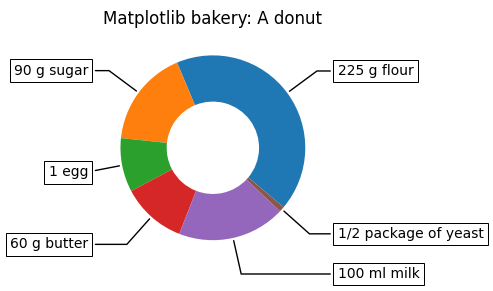

In [19]:
#Referencia/Ejemplo para refinar gráfico----------------------------------------------------------------------------------------------------------------------------------------
#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# =============================================================================
# Metricas Nacionales
# =============================================================================

#Se utiliza la QueryTotal para las operaciones
#Se debe filtrar por el ano actual

QueryTotalA = QueryTotal.loc[QueryTotal['Ano'] == AnoReg]

#Total transado nacional en USD, CLP , CLF
NacTotTransUSDA = QueryTotalA['MONTOUSD'].sum()
NacTotTransCLPA = QueryTotalA['MONTOCLP'].sum()
NacTotTransCLFA = QueryTotalA['MONTOCLF'].sum ()
print(NacTotTransUSDA)
print(NacTotTransCLPA)
print(NacTotTransCLFA)

#Total OC
NacTotOCA = QueryTotalA['CantOC'].sum()


#Total proveedores con OC
NacProvTrans = QueryTotalProv['CantProveedores'].sum()


#Proporcion numero prov pyme vs total
NacTotProvA = QueryTotalProv['CantProveedores'].sum()

#Porcentaje de Pyme vs total proveedores
NacFiltPymeA = QueryTotalProv.loc[QueryTotalProv['Tamano'].isin(['MiPyme'])]
#Cuento las filas de la columna Ano como referencia, puede ser cualquier otra
NacTotPymeA = NacFiltPymeA['CantProveedores'].sum()
NacVarProvPymeA = (NacTotPymeA/NacTotProvA)*100

#Total proveedores transando 

#NacProvPart = QProv['Transan'].count()
NacProvPart=len(QProv)

#Total monto Convenio Marco
NacFiltCM = QueryTotalA[QueryTotalA['ProcedenciaOC'] == 'Convenio Marco']
NacFiltCMUSD = NacFiltCM['MONTOUSD'].sum()
NacFiltCMCLP = NacFiltCM['MONTOCLP'].sum()
             

NacFiltPymeTransA = QueryTotalA.loc[QueryTotalA['Tamano'].isin(['MiPyme'])]                                  
#Transado por Pyme
NacTransPymeUSDA =  NacFiltPymeTransA['MONTOUSD'].sum()
NacTransPymeCLFA =  NacFiltPymeTransA['MONTOCLF'].sum()
NacTransPymeCLPA =  NacFiltPymeTransA['MONTOCLP'].sum()

#Var transado pyme total
NacVarTransPymeA = (NacTransPymeCLFA/NacTotTransCLFA)*100

#Top 3 participacion Mipymes (Usa qery de regiones)
#Arreglo de regiones
ListReg = list(QueryReg['Region'].unique())
#DF vacio
NacPymePart = pd.DataFrame(columns = ['Region','PYME','Grande','Total'])

#Itero por region calculando porcentage de PYME en los montos totales
for i in ListReg:
#    print(i)
    RegFiltIter = QueryReg.loc[(QueryReg['Region'] == i) & (QueryReg['Ano'] == AnoReg)]
    RegFiltPymeA = RegFiltIter.loc[RegFiltIter['Tamano'].isin(['MiPyme'])]
    
    RegTotTransCLFA = RegFiltIter['MONTOCLF'].sum()
    RegTotTransPymeCLFA = RegFiltPymeA['MONTOCLF'].sum()
    VarTransPymeA = (RegTotTransPymeCLFA/RegTotTransCLFA)*100
    VarGrande = 100-VarTransPymeA
    NuevaFila = pd.DataFrame({'Region':'Atacama', 'PYME':VarTransPymeA, 'Grande': VarGrande, 'Total': 100},index=[0])
    NacPymePart= pd.concat([NuevaFila,NacPymePart.loc[:]]).reset_index(drop=True)
    #NacPymePart = NacPymePart.concat({'Region':i, 'PYME':VarTransPymeA, 'Grande': VarGrande, 'Total': 100} , ignore_index=True)



NacPymePart = NacPymePart.sort_values('PYME', ascending = False) 
   
#Generar top 3 pyme
NacTop3Pyme = NacPymePart.head(3)

10996091751.736164
8935065764637.406
249898249.66166365


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_14056\4181201334.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  NacPymePart= pd.concat([NuevaFila,NacPymePart.loc[:]]).reset_index(drop=True)


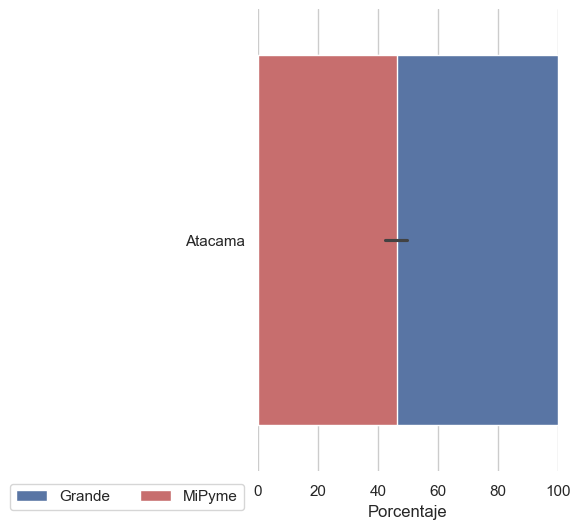

In [21]:
# =============================================================================
# Grafico pyme en Seaborn
# =============================================================================

#DF a utilizar: NacPymePart
#Cambiando columna a index para grafico
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))
#ax.invert_xaxis()

# Plot the total crashes
sns.set_color_codes("deep")
#Asignar a variable primer grafico
GrafPyme =sns.barplot(x='Total', y="Region", data=NacPymePart,
            label="Grande", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
splot=sns.barplot(x="PYME", y="Region", data=NacPymePart,
            label="MiPyme", color="r")
#splot.set_title("Montos 2021 MiPyme sobre total transado por región", fontweight="bold"
#                                   ,fontsize = 12)



#anotar cantidad de porcentaje por barra
for p in itertools.islice(splot.patches,16,32):
    splot.annotate(format(p.get_width(), '.1f')+'%', # formato 
                   (p.get_width() - 10, p.get_y()-0.1), # coordenada donde imprimir la cifra
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, -12), 
                   textcoords = 'offset points')



# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True,bbox_to_anchor=(-0.02, -0.1))
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Porcentaje")
sns.despine(left=True, bottom=True)
#Ajustando espacio para que regiones no sean cortadas
plt.subplots_adjust(left=0.4, right =0.9 )




fig = GrafPyme.get_figure()
fig.savefig(url+'GrafPyme.jpg') 

#Pymechart.savefig(url+"output.png")
#Guardar chart

In [22]:
# =============================================================================
# Setteo Datos Regionales
# =============================================================================
                                  
RegFechas = {'Antofagasta':             '8 de noviembre',
            'Araucanía':                '22 de noviembre',
            'Arica y Parinacota':       '7 de noviembre',
            'Atacama':                  '8 de noviembre',
            'Aysén':                    '22 de noviembre',
            'Bío-Bío':                  '16 de noviembre',
            'Coquimbo':                 '6 de noviembre',
            "Lib. Gral. Bdo. O'Higgins":'14 de noviembre',
            'Los Lagos':                '20 de noviembre',
            'Los Ríos':                 '30 de noviembre',
            'Magallanes y Antártica':   '21 de noviembre',
            'Maule':                    '14 de noviembre',
            'Metropolitana':            '16, 17 y 20 de noviembre',
            'Ñuble':                    '17 de noviembre',
            'Tarapacá':                 '9 de noviembre',
            'Valparaíso':               '13 de noviembre'}

RegNomb =   {'Antofagasta':             {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}


In [23]:
# =============================================================================
# Generar Iterador  con metricas Regionales
# =============================================================================
                                  
#Iterando para que r tome el valor de todas las regiones disponibles
for r in ListReg:

    Reg = r
    #Reg = 'Antofagasta'
                                                      
    #Convencion: A = Año presente , B = Año pasado         
    RegFiltA = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoReg)]
    
    #Total transado por region en USD, CLP , CLF
    RegTotTransUSDA = RegFiltA['MONTOUSD'].sum()
    RegTotTransCLPA = RegFiltA['MONTOCLP'].sum()
    RegTotTransCLFA = RegFiltA['MONTOCLF'].sum()
    
    #Calculo de monto en CLF para calcular variacion con año pasado
    RegFiltB = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoRegM1)]
    RegTotTransCLFB = RegFiltB['MONTOCLF'].sum()
    
    #Calculo de variacion anual
    VarRegCLF = (RegTotTransCLFA - RegTotTransCLFB)/ RegTotTransCLFB *100
    
    #Total OC region
    RegTotOCA = RegFiltA['CantOC'].sum()
    
    #Calculando datos pyme
    RegFiltPymeA = RegFiltA.loc[RegFiltA['Tamano'].isin(['MiPyme'])]
    RegTotTransPymeCLFA = RegFiltPymeA['MONTOCLF'].sum()
    RegTotTransPymeCLPA = RegFiltPymeA['MONTOCLP'].sum()
    #Variacion transado pyme vs total transado
    VarTransPymeA = (RegTotTransPymeCLFA/RegTotTransCLFA)*100
    
    #Ranking top 3 instituciones con mayor monto transado
    RankFiltTransA = RegFiltA.groupby(by = 'NombreInstitucion')['MONTOCLP'].sum().sort_values(ascending = False).head(3)
    RankFiltTransA = RankFiltTransA.to_frame()
    RankFiltTransA= RankFiltTransA.reset_index()
    RankFiltTransA['NombreInstitucion'] = RankFiltTransA['NombreInstitucion'].str.upper()
    
    #Ranking top 3 Rubros con mayor monto transado
    RankRubroReg =  QueryRegRubro.loc[QueryRegRubro['Region'] == Reg]
    
    #Ranking top 3 OC de region para word
    RegRankOC = QTop10.loc[QTop10['Region'] == Reg]
    RegRankOC = RegRankOC[['NombreInstitucion','CodigoOC','MotivoCompra','NombreSucursal','USD_BRUTO']]
    
    #Version para word
    
    RegRankOCWord = RegRankOC.rename({'NombreInstitucion': 'Institución', 'CodigoOC': 'Código orden de compra'
                                      ,'MotivoCompra':'Motivo de la compra'
                                      ,'NombreSucursal': 'Proveedor','USD_BRUTO': 'Monto comprometido en US$'}, axis=1)
    
        
    #Cambiando formato de Dolares desde float a str
    RegRankOCWord['Monto comprometido en US$']  =  RegRankOCWord['Monto comprometido en US$'].astype(int) 
    RegRankOCWord['Monto comprometido en US$'] = RegRankOCWord['Monto comprometido en US$'].apply(itanum)  
    RegRankOCWord['Monto comprometido en US$']  = RegRankOCWord['Monto comprometido en US$'].astype(str)


Antofagasta
{'ano': '2023', 'anoAnt': '2022'}
{'nom': 'Región de Antofagasta', 'nomCt': 'Antofagasta', 'mtoSecReg1': 'Obras Públicas', 'mtoSecRegCLP1': '$84.044.175.663', 'mtoSecRegPct1': '37,1%', 'mtoSecReg2': 'Municipalidades', 'mtoSecRegCLP2': '$67.981.176.868', 'mtoSecRegPct2': '30,0%', 'mtoSecReg3': 'Salud', 'mtoSecRegCLP3': '$48.288.256.621', 'mtoSecRegPct3': '21,3%', 'mtoSecReg4': 'Gob. Central, Universidades', 'mtoSecRegCLP4': '$20.078.708.007', 'mtoSecRegPct4': '8,9%', 'mtoSecRegGrf': <docxtpl.inline_image.InlineImage object at 0x00000257F8C61DD0>, 'fechaVisita': '8 de noviembre', 'asistentes': 5500, 'ano': '2023', 'anoAnt': '2022'}

Araucanía
{'ano': '2023', 'anoAnt': '2022'}
{'nom': 'Región de La Araucanía', 'nomCt': 'La Araucanía', 'mtoSecReg1': 'Municipalidades', 'mtoSecRegCLP1': '$150.202.329.808', 'mtoSecRegPct1': '36,3%', 'mtoSecReg2': 'Salud', 'mtoSecRegCLP2': '$130.062.768.757', 'mtoSecRegPct2': '31,5%', 'mtoSecReg3': 'Obras Públicas', 'mtoSecRegCLP3': '$61.522.739.4

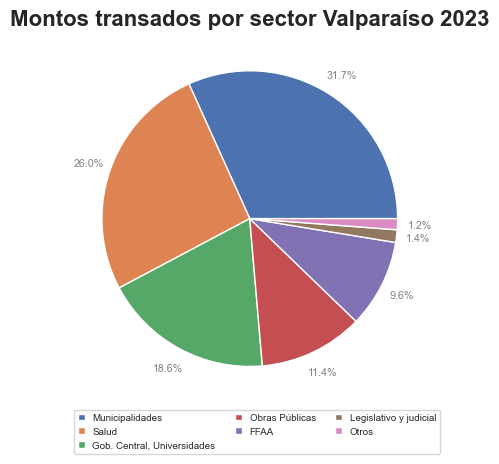

In [24]:

# =============================================================================
# Contexto(Dic) Regional para Template
# =============================================================================

#Retorna diccionario con Top especificado de Sectores por Monto transado y región, Moneda a especificar
#Región, Tamaño top, moneda a usar
#llamarquery?
def agregarMontoSectorRegion(r, top, mnd):

    #Seleccionar filas de la región y total de monto a usar
    dfSecReg = QSecReg.loc[QSecReg['region'] == r]
    totMnt = dfSecReg['Monto_Bruto_'+mnd].sum()
    
    #Seleccionar filas del top
    dfSecReg = dfSecReg.head(top)
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    dfSecReg.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    nctxt = {}
    for i,row in dfSecReg.iterrows():
        nctxt['mtoSecReg'+str(i+1)] = row['Sector']
        nctxt['mtoSecReg'+mnd+str(i+1)] = '$'+str(itanum(row['Monto_Bruto_'+mnd]))
        nctxt['mtoSecRegPct'+str(i+1)] = pctaje(100*row['Monto_Bruto_'+mnd]/totMnt)
    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(r, mnd, titGraf):
    dfSecReg = QSecReg.loc[QSecReg['region'] == r]
    graf_torta(dfSecReg['Monto_Bruto_'+mnd], dfSecReg['Sector'], titGraf)
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'mtoSecRegGrf' : img}
    return dctGrf


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')


#Importar template
docu = DocxTemplate("docxtpl.docx")

#Variables que especifican requerimientos
topMntSecReg = 4
mndMntSecReg = 'CLP'

#Settear diccionario nacional
contextoNac = {'ano' : str(AnoReg),
               'anoAnt' : str(AnoRegM1)}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

for r in ListReg:
    print('')
    print(r)
    contexto = setContextoReg(r)
    contexto.update(agregarMontoSectorRegion(r, topMntSecReg, mndMntSecReg))

    titGrafSecReg = contexto['nomCt'] + ' ' + str(AnoReg)
    contexto.update(agregarGrafMontoSectorRegion(r, mndMntSecReg, titGrafSecReg)) #remover grafico despues de renderizar

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    print(contextoNac)
    print(contexto)
    docu.render(contexto)
    os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    nomDocu = 'ProtoReporte ' + contexto['nomCt'] + ' ' + str(AnoReg)
    docu.save('reportes/'+nomDocu+'.docx')

In [ ]:
# =============================================================================
# Generar Iterador  con metricas Regionales
# =============================================================================
                                  
#Iterando para que r tome el valor de todas las regiones disponibles
for r in ListReg:

    Reg = r
    #Reg = 'Antofagasta'
                                                      
    #Convencion: A = Año presente , B = Año pasado         
    RegFiltA = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoReg)]
    
    #Total transado por region en USD, CLP , CLF
    RegTotTransUSDA = RegFiltA['MONTOUSD'].sum()
    RegTotTransCLPA = RegFiltA['MONTOCLP'].sum()
    RegTotTransCLFA = RegFiltA['MONTOCLF'].sum()
    
    #Calculo de monto en CLF para calcular variacion con año pasado
    RegFiltB = QueryReg.loc[(QueryReg['Region'] == Reg) & (QueryReg['Ano'] == AnoRegM1)]
    RegTotTransCLFB = RegFiltB['MONTOCLF'].sum()
    
    #Calculo de variacion anual
    VarRegCLF = (RegTotTransCLFA - RegTotTransCLFB)/ RegTotTransCLFB *100
    
    #Total OC region
    RegTotOCA = RegFiltA['CantOC'].sum()
    
    #Calculando datos pyme
    RegFiltPymeA = RegFiltA.loc[RegFiltA['Tamano'].isin(['MiPyme'])]
    RegTotTransPymeCLFA = RegFiltPymeA['MONTOCLF'].sum()
    RegTotTransPymeCLPA = RegFiltPymeA['MONTOCLP'].sum()
    #Variacion transado pyme vs total transado
    VarTransPymeA = (RegTotTransPymeCLFA/RegTotTransCLFA)*100
    
    #Ranking top 3 instituciones con mayor monto transado
    RankFiltTransA = RegFiltA.groupby(by = 'NombreInstitucion')['MONTOCLP'].sum().sort_values(ascending = False).head(3)
    RankFiltTransA = RankFiltTransA.to_frame()
    RankFiltTransA= RankFiltTransA.reset_index()
    RankFiltTransA['NombreInstitucion'] = RankFiltTransA['NombreInstitucion'].str.upper()
    
    #Ranking top 3 Rubros con mayor monto transado
    RankRubroReg =  QueryRegRubro.loc[QueryRegRubro['Region'] == Reg]


    #Ranking top 3 OC de region para word
    RegRankOC = QTop10.loc[QTop10['Region'] == Reg]
    RegRankOC = RegRankOC[['NombreInstitucion','CodigoOC','MotivoCompra','NombreSucursal','USD_BRUTO']]
    
    #Version para word
    
    RegRankOCWord = RegRankOC.rename({'NombreInstitucion': 'Institución', 'CodigoOC': 'Código orden de compra'
                                      ,'MotivoCompra':'Motivo de la compra'
                                      ,'NombreSucursal': 'Proveedor','USD_BRUTO': 'Monto comprometido en US$'}, axis=1)
    
        
    #Cambiando formato de Dolares desde float a str
    RegRankOCWord['Monto comprometido en US$']  =  RegRankOCWord['Monto comprometido en US$'].astype(int) 
    RegRankOCWord['Monto comprometido en US$'] = RegRankOCWord['Monto comprometido en US$'].apply(itanum) 
    RegRankOCWord['Monto comprometido en US$']  = RegRankOCWord['Monto comprometido en US$'].astype(str)


    ####### Top Sectores por región
    #Cambiar par arriba
    
    #DataFrame de la región
    dfSecReg = QSecReg.loc[QSecReg['region'] == Reg]
    

    #Top sectores mas tranzan en la reg
    SecReg1 = dfSecReg.iloc[0]['Sector']
    SecReg2 = dfSecReg.iloc[1]['Sector']
    SecReg3 = dfSecReg.iloc[2]['Sector']
    SecReg4 = dfSecReg.iloc[3]['Sector']

    #Monto en USD de los sectores
    SecRegCP1 = dfSecReg.iloc[0]['Monto_Bruto_CLP']
    SecRegCP2 = dfSecReg.iloc[1]['Monto_Bruto_CLP']
    SecRegCP3 = dfSecReg.iloc[2]['Monto_Bruto_CLP']
    SecRegCP4 = dfSecReg.iloc[3]['Monto_Bruto_CLP']

    #Porcentaje monto transado sector sobre total regional
    SecRegTot = dfSecReg['Monto_Bruto_CLP'].sum()
    SecRegPct1 = SecRegCP1*100/SecRegTot
    SecRegPct2 = SecRegCP2*100/SecRegTot
    SecRegPct3 = SecRegCP3*100/SecRegTot
    SecRegPct4 = SecRegCP4*100/SecRegTot


    ###### CA en la region, 2023 vs 2022
 
    #DataFrame de la región
    dfCAReg = QCAReg.loc[QCAReg['Region'] == Reg]

    #Monto regional CA periodo actual
    CARegCPA = dfCAReg.iloc[0]['MONTOCLP_CAg']
    
    #Cantidad regional OC periodo actual y diferencia con año anterior
    CARegOCA = dfCAReg.iloc[0]['CantOC_CAg']
    CARegOCB = dfCAReg.iloc[1]['CantOC_CAg']
    CARegOCDif = CARegOCA - CARegOCB

    #Diferencia nominal porcentual del monto regional de AC periodo actual sobre periodo anterior
    CARegUSA = dfCAReg.iloc[0]['MONTOUSD_CAg']
    CARegUSB = dfCAReg.iloc[1]['MONTOUSD_CAg']
    CARegUSVarPct = (CARegUSA - CARegUSB)*100/CARegUSB


    # =============================================================================
    # Crear Documento word
    # =============================================================================
    
    
    #Crear objeto documento  ()
    #Crear sobre un template para que quede con los logos de chilecompra
    #Obs, no se pueded
    document = docx.Document('template.docx')
    print(document.styles)

    
    #"Agregar espacio
    #document.add_heading(" " , 0) 
    #Agregar titulo. el 0 indica el tipo de titulo
    #document.add_heading('Datos regionales '  + str(AnoReg) + " " + str(Reg)  , 0)
    #document.add_heading('Datos regionales ' + str(AnoReg) + " " + str(Reg)  , 0)
    #document.add_heading('Datos regionales ' +Sem+ ' Trimestre ' + str(AnoReg) + "   " + str(Reg)  , 0)
    
    #Agregar primer título en 
    # document.add_heading('Cifras Regionales', 1) #no se usa en el documento modelo (año 2022)
    
    #Generar espacios
    #document.add_paragraph(" ")
    #Agregar texto en negra. Solo se agregan fuentes a nivel de run
    parBold1 = document.add_paragraph()
    #Agrega espacio desúés de paragraph 

    ### Semestre ###
    runBold1 =parBold1.add_run("ChileCompra se despliega en " + Reg + " para capacitar a compradores y proveedores en cambios a la Ley de Compras Públicas")
    
    ### Trimestre ###
    #runBold1 =parBold1.add_run("US$ " + str(itanum(int(RegTotTransUSDA))) + " se transaron en Mercado Público durante el " + Sem +  " trimestre de " 
    #                                  + str(AnoReg) + " en la región de " +str(Reg)+".")
    
    ### Ano ###
    #runBold1 =parBold1.add_run("US$ " + str(itanum(int(RegTotTransUSDA))) + " se transaron en Mercado Público durante el " 
    #                                  + str(AnoReg) + " en la región de " +str(Reg)+".")
    
    runBold1.bold = True
    runBold1.font.size = shared.Pt(14)
    parBold1.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    document.add_paragraph(" ")
    #parBold1.font.size = Pt(12)
    #Segundo paragraph solo en 

    parBold2 = document.add_paragraph()

    #parBold2.style='Párrafo de lista'
    parBold2.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    
    runBold2 = parBold2.add_run("• Los funcionarios y proveedores de la región conocieron las nuevas exigencias en materia de probidad y transparencia que entran a regir de inmediato apenas se publique la ley de compras públicas, que se encuentra en último trámite en el Tribunal Constitucional.")
    runBold2.bold = True
    runBold2.font.size = shared.Pt(10)
    document.add_paragraph()

    
    parBold3 = document.add_paragraph()
    parBold3.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    
    runBold3 = parBold3.add_run("• Durante el " + str(AnoReg) + " se transaron entre enero y agosto " + str(itanum(int(round(RegTotTransCLPA/1000000)))) + 
                                " millones de pesos a través de www.mercadopublico.cl en la Región de " + str(Reg) + " con "+str(itanum(int(RegTotOCA))) + 
                                " órdenes de compra emitidas por los diferentes organismos públicos.")
    runBold3.bold = True
    runBold3.font.size = shared.Pt(10)
    document.add_paragraph(" ")
    
    
    par01Reg = document.add_paragraph("Este " + RegFechas[Reg] + ", ChileCompra visitó la región de " + Reg + 
                                     " para dar a conocer a los usuarios compradores y proveedores del Estado las novedades de la modernización de la Ley de Compras Públicas, cuyo proyecto se encuentra en el último trámite en el Tribunal Constitucional y que traerá importantes avances en materia de transparencia, probidad, impulso a las Empresas de Menor Tamaño y economía circular, entre otros.") 
    par01Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par01Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")




    par02Reg = document.add_paragraph() 
    par02Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #par02Reg.runs[0].font.size = shared.Pt(10)
    run02Reg = par02Reg.add_run("[AGREGAR USUARIOS PARTICIPANTES]")
    run02Reg.font.bold = True
    run02Reg.font.underline = True
    run02Reg.font.size = shared.Pt(10)
    run02Reg = par02Reg.add_run(" usuarios entre funcionarios de entidades públicas regionales y proveedores conocieron las nuevas disposiciones en materia de probidad y transparencia que establece el capítulo 7 de la nueva ley, las que rigen de inmediato apenas se publique la ley, y que dicen relación con un mayor resguardo de los conflictos de interés en las compras públicas, lo que implica cambios relevantes en las compras de entidades del Estado. ")
    run02Reg.font.size = shared.Pt(10)
    document.add_paragraph(" ")


    parBold4 = document.add_paragraph()
    parBold4.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    runBold4 = parBold4.add_run("Principales puntos de la reforma de compras públicas que rigen de inmediato")
    runBold4.bold = True
    runBold4.font.size = shared.Pt(10)
    document.add_paragraph(" ")
    
    
    par03Reg = document.add_paragraph("Se amplía el universo de personas relacionadas inhábiles para contratar con los organismos del Estado, incluyendo no solo a directivos de los servicios que hacen la compra (hasta jefaturas de departamento) sino también a todos los funcionarios, aunque no ejerzan jefaturas, y a las personas vinculadas a estos por parentesco, así como las sociedades en que ellos sean parte o tengan la calidad de beneficiarios finales. En el caso de los directivos, la inhabilidad se extenderá hasta un año desde el cese del cargo. Además, se publicará en el sistema el personal que participe en los procesos de compra.") 
    par03Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par03Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par04Reg = document.add_paragraph("También se amplían las causales de inhabilidad para participar del Registro de Proveedores y se fortalece la normativa aplicable a grupos empresariales relacionados y al concepto de “beneficiarios finales”, junto con regular la inadmisibilidad de las ofertas en caso de que en un procedimiento de contratación se presenten ofertas simultáneas respecto de un mismo bien o servicio por parte de empresas del mismo grupo empresarial o relacionadas entre sí.") 
    par04Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par04Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par05Reg = document.add_paragraph("Al Banco Central, a las empresas públicas y a las sociedades en que el Estado tenga más de 50% de participación también se les aplicarán las normas de Probidad y Transparencia.") 
    par05Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par05Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    parBold5 = document.add_paragraph()
    parBold5.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    runBold5 = parBold5.add_run("6.368 usuarios se han capacitado a lo largo del país")
    runBold5.bold = True
    runBold5.font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par06Reg = document.add_paragraph("Durante noviembre, la Dirección ChileCompra desarrollará un ciclo de cursos presenciales que abordan la modernización de la Ley de Compras Públicas, cuyo proyecto se encuentra en el último trámite en el Tribunal Constitucional y que traerá importantes avances en materia de transparencia, probidad, impulso a las Empresas de Menor Tamaño y economía circular, entre otros.") 
    par06Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par06Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par07Reg = document.add_paragraph("En total se realizarán 36 capacitaciones presenciales, que tienen como objetivo que los usuarios y usuarias encargadas de las compras de los distintos organismos del Estado y las personas y empresas que buscan vender sus bienes y servicios, se actualicen respecto a los cambios normativos que impactarán en la gestión de la contratación pública.  Estas se suman a las realizadas en la Región Metropolitana en forma presencial y virtual desde el 3 de octubre sumando un total de 6.368 usuarios capacitados.") 
    par07Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par07Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par08Reg = document.add_paragraph("Los cursos son gratuitos y requieren inscripción previa y se desarrollan en colaboración con las Seremis del Ministerio de Hacienda, Sercotec, Inacap, la Delegación Presidencial Regional de Atacama, la Universidad Católica del Norte, la Universidad de Talca y la Universidad de Concepción.") 
    par08Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par08Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    par09Reg = document.add_paragraph('“Se trata del primer despliegue de funcionarios de ChileCompra en distintas regiones del país desde la pandemia y responde al interés que tenemos como institución de llegar directamente a compradores y proveedores en lo que respecta a los cambios normativos que trae la nueva Ley de Compras Públicas, que esperamos se publique en los próximos meses. Estamos trabajando intensamente para dar a conocer los cambios a la norma, especialmente los que tienen relación con probidad y transparencia que entrarán en vigencia inmediatamente tras publicación en el Diario Oficial”, indicó la directora de ChileCompra, Verónica Valle.') 
    par09Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par09Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")

    #####AGREGAR HV
    par010Reg = document.add_paragraph("Para participar los usuarios sólo deben revisar la oferta de cursos e inscribirse.  ") 
    par010Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par010Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    
    ################################
    ###    Contenido Anterior    ###
    ################################


    parBold6 = document.add_paragraph()
    parBold6.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    runBold6 = parBold6.add_run("$" + str(itanum(int(round(RegTotTransCLPA/1000000)))) + " millones se transaron en Mercado Público entre enero y agosto " 
                                      + str(AnoReg) + " en la región de " +str(Reg)+".")
    ###########CAMBIAR A PESO
    runBold6.bold = True
    runBold6.font.size = shared.Pt(10)
    document.add_paragraph(" ")


    ### Semestre ###
    #par1Reg = document.add_paragraph("Entre enero y agosto de " + str(AnoReg) + " se transaron " + str(itanum(int(RegTotTransUSDA))) + " dólares equivalentes a "+ 
    #                                 str(itanum(int(RegTotTransCLPA))) + " pesos a través de Mercado Público en la Región de "+ str(Reg) +
    #                                 ". De ese total, las micro, pequeñas y medianas empresas se adjudicaron "+str(itanum(int(RegTotTransPymeCLPA)))+
    #                                 " pesos, es decir, un "+str(itanum(int(VarTransPymeA)))+"% del monto total.") 
    
    #par1Reg = document.add_paragraph("Entre enero y agosto de " + str(AnoReg) + " se transaron " + str(itanum(int(round(RegTotTransCLPA/1000000)))) + " millones de pesos (US$ " + 
    #                                 str(itanum(int(round(RegTotTransUSDA/1000000)))) + " millones) a través de www.mercadopublico.cl en la Región de " + str(Reg) +
    #                                 " con "+str(itanum(int(RegTotOCA))) + " órdenes de compra emitidas por los diferentes organismos públicos.")


    par1Reg = document.add_paragraph("Durante " + str(AnoReg) + " se transaron " + str(itanum(int(round(RegTotTransCLPA/1000000)))) + " millones de pesos (US$ " + 
                                     str(itanum(int(round(RegTotTransUSDA/1000000)))) + " millones) a través de www.mercadopublico.cl en la Región de " + str(Reg) +
                                     " con "+str(itanum(int(RegTotOCA))) + " órdenes de compra emitidas por los diferentes organismos públicos.")
    par1Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par1Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")


    ### Ano ###
    #par1Reg = document.add_paragraph("Durante el " + str(AnoReg) + " se transaron " + str(itanum(int(RegTotTransUSDA))) + " dólares equivalentes a "+ 
    #                                 str(itanum(int(RegTotTransCLPA))) + " pesos a través de Mercado Público en la Región de "+ str(Reg) +
    #                                 ". De ese total, las micro, pequeñas y medianas empresas se adjudicaron "+str(itanum(int(RegTotTransPymeCLPA)))+
    #                                 " pesos, es decir, un "+str(itanum(int(VarTransPymeA)))+"% del monto total.") 
    
    ### Trimsestre ###
    #par1Reg = document.add_paragraph("Durante el " +Sem+ " trimestre de " + str(AnoReg) + " se transaron " + str(itanum(int(RegTotTransUSDA))) + " dólares equivalentes a "+ 
    #                                 str(itanum(int(RegTotTransCLPA))) + " pesos a través de Mercado Público en la Región de "+ str(Reg) +
    #                                 ". De ese total, las micro, pequeñas y medianas empresas se adjudicaron "+str(itanum(int(RegTotTransPymeCLPA)))+
    #                                 " pesos, es decir, un "+str(itanum(int(VarTransPymeA)))+"% del monto total.") 




    ### Semestre ###
    #par2Reg = document.add_paragraph("Respecto al mismo periodo de "+ str(AnoRegM1)+
    #                                ", se experimentó una variación de "+str(itanum(int(VarRegCLF)))+
    #                                "% en términos reales, esto a partir de las "+str(itanum(int(RegTotOCA)))+
    #                                " órdenes de compra emitidas por los diferentes organismos públicos.") 
   
    
    ### Ano ###
    #par2Reg = document.add_paragraph("Respecto al "+ str(AnoRegM1)+
    #                                 ", se experimentó una variación de "+str(itanum(int(VarRegCLF)))+
    #                                 "% en términos reales, esto a partir de las "+str(itanum(int(RegTotOCA)))+
    #                                 " órdenes de compra emitidas por los diferentes organismos públicos.")
    
    ### Trimestre ###
    #par2Reg = document.add_paragraph("Respecto al "+Sem+" trimestre del "+ str(AnoRegM1)+
    #                                 ", se experimentó una variación de "+str(itanum(int(VarRegCLF)))+
    #                                 "% en términos reales, esto a partir de las "+str(itanum(int(RegTotOCA)))+
    #                                 " órdenes de compra emitidas por los diferentes organismos públicos.") 
    
    #document.add_paragraph(" ")
    ### Semestre ###
    par3Reg = document.add_paragraph("En la Región, en este "+
                                     " periodo, las instituciones con mayor participación fueron: "+RankFiltTransA.iloc[0]['NombreInstitucion']+
                                     " ("+ str(itanum(int(RankFiltTransA.iloc[0]['MONTOCLP'])))+ " pesos); "+RankFiltTransA.iloc[1]['NombreInstitucion']+
                                     " ("+ str(itanum(int(RankFiltTransA.iloc[1]['MONTOCLP'])))+ " pesos); " +RankFiltTransA.iloc[2]['NombreInstitucion']+
                                     " ("+ str(itanum(int(RankFiltTransA.iloc[2]['MONTOCLP'])))+
                                     " pesos). Por su parte, los rubros más solicitados fueron: "+RankRubroReg.iloc[0]['RubroN1']+
                                     " (US$ "+str(itanum(int(RankRubroReg.iloc[0]['MONTOUSD'])))+"); "+RankRubroReg.iloc[1]['RubroN1']+
                                     " (US$ "+str(itanum(int(RankRubroReg.iloc[1]['MONTOUSD'])))+"); "+RankRubroReg.iloc[2]['RubroN1']+
                                     " (US$ "+str(itanum(int(RankRubroReg.iloc[2]['MONTOUSD'])))+")."
                                     )
    par3Reg.runs[0].font.size = shared.Pt(10)
   
    
    ### Ano ###
    #par3Reg = document.add_paragraph("En la Región, las instituciones con mayor participación fueron: "+RankFiltTransA.iloc[0]['NombreInstitucion']+
    #                                 " ("+ str(itanum(int(RankFiltTransA.iloc[0]['MONTOCLP'])))+ " pesos); "+RankFiltTransA.iloc[1]['NombreInstitucion']+
    #                                 " ("+ str(itanum(int(RankFiltTransA.iloc[1]['MONTOCLP'])))+ " pesos); " +RankFiltTransA.iloc[2]['NombreInstitucion']+
    #                                 " ("+ str(itanum(int(RankFiltTransA.iloc[2]['MONTOCLP'])))+
    #                                 " pesos). Por su parte, los rubros más solicitados fueron: "+RankRubroReg.iloc[0]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[0]['MONTOUSD'])))+"); "+RankRubroReg.iloc[1]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[1]['MONTOUSD'])))+"); "+RankRubroReg.iloc[2]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[2]['MONTOUSD'])))+")."
    #                                 )
    

    ### Trimestre ###
    #par3Reg = document.add_paragraph("En la Región, en este "+Sem+
    #                                " trimestre, las instituciones con mayor participación fueron: "+RankFiltTransA.iloc[0]['NombreInstitucion']+
    #                                " ("+ str(itanum(int(RankFiltTransA.iloc[0]['MONTOCLP'])))+ " pesos); "+RankFiltTransA.iloc[1]['NombreInstitucion']+
    #                               " ("+ str(itanum(int(RankFiltTransA.iloc[1]['MONTOCLP'])))+ " pesos); " +RankFiltTransA.iloc[2]['NombreInstitucion']+
    #                                 " ("+ str(itanum(int(RankFiltTransA.iloc[2]['MONTOCLP'])))+
    #                                 " pesos). Por su parte, los rubros más solicitados fueron: "+RankRubroReg.iloc[0]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[0]['MONTOUSD'])))+"); "+RankRubroReg.iloc[1]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[1]['MONTOUSD'])))+"); "+RankRubroReg.iloc[2]['RubroN1']+
    #                                 " (US$ "+str(itanum(int(RankRubroReg.iloc[2]['MONTOUSD'])))+")."
    #                                 )
    
    par3Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    document.add_paragraph(" ")
    ### Semestre ###              
    par3Reg = document.add_paragraph("Las principales órdenes de compra, durante " + str(AnoReg) + ", fueron las siguentes:")     
    
    ### Ano ###
    #par3Reg = document.add_paragraph("Las principales órdenes de compra, durante el "+ str(AnoReg)+", fueron las siguentes:")     
    
    #xTrimestre
    #par3Reg = document.add_paragraph("Las principales órdenes de compra, durante el "+Sem+" trimestre, fueron las siguentes:")       
    
    document.add_paragraph(" ")
    #Tabla top OC por region
    #Indices parten en cero, igual que en python
    
    t = document.add_table(RegRankOCWord.shape[0]+1, RegRankOCWord.shape[1])
    
    # add the header rows.
    for j in range(RegRankOCWord.shape[-1]):
        t.cell(0,j).text = RegRankOCWord.columns[j]
    
    # add the rest of the data frame
    for i in range(RegRankOCWord.shape[0]):
        for j in range(RegRankOCWord.shape[-1]):
            t.cell(i+1,j).text = str(RegRankOCWord.values[i,j])
            for paragraph in t.cell(i + 1, j).paragraphs:
                for run in paragraph.runs:
                    run.font.size = shared.Pt(10)
        
    t.autofit = True
    t.style =  'EstiloDCCP'

    document.add_paragraph(" ")
    document.add_paragraph(" ")
    ### Sectores por Región

    parBold7 = document.add_paragraph()
    runBold7 = parBold7.add_run("El sector de " + SecReg1 + " lidera las compras con $" + str(itanum(int(round(SecRegCP1/1000000)))) + " millones transados")
    runBold7.bold = True
    runBold7.font.size= shared.Pt(10)
    parBold7.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    document.add_paragraph(" ")

    par4Reg = document.add_paragraph("Respecto de las transacciones en Mercado Público por sector comprador en " + Reg + ", " + SecReg1 + " lideran las compras con " + 
                                     str(itanum(int(round(SecRegCP1/1000000)))) + " millones de pesos transados, lo que equivale a un " + str((round(SecRegPct1))) + 
                                     "% de las transacciones por sector en la región. Le sigue el sector " + SecReg2 + " con " + str(itanum(int(round(SecRegCP2/1000000)))) + 
                                     " millones transados, esto un " + str((round(SecRegPct2))) + "%, luego viene " + SecReg3 + " con " + str(itanum(int(round(SecRegCP3/1000000)))) + 
                                     " millones de pesos transados (" + str((round(SecRegPct3))) + "%) y luego " + SecReg4 + " con " + str(itanum(int(round(SecRegCP4/1000000)))) + 
                                     " millones de pesos transados (" + str((round(SecRegPct4))) + "%). ") 
    
    par4Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par4Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")

    
    ################################################################
    #######           Gráfico Sectores por Región           ########
    ################################################################
    
    #### EVALUAR SI SE PONE DIRECTO EL DF
    titGraf = str(AnoReg) + ' en ' + Reg
    graf_torta(dfSecReg['Monto_Bruto_CLP'], dfSecReg['Sector'], titGraf)
    # La dunción debería retornar la imagen
    grafico1 = document.add_picture(titGraf +'.png'
                         , width=Inches(6)
                         )
    
    grafico1.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    os.remove(titGraf +'.png')

    
    document.add_paragraph(" ")


    ### Monto y OC Compra Agil por Región, 2023 vs 2022
    par5Reg = document.add_paragraph("En la región de " + Reg + 
                                     " se generaron oportunidades por la modalidad Compra Ágil -que permite mayor participación de las Mipymes en compras de menores montos (igual o menor a 30 UTM)- por $" + 
                                     str(itanum(int(round(CARegCPA/1000000)))) + " millones, las que se tradujeron en " + str(itanum(int(CARegOCA))) + 
                                     " órdenes de compra emitidas por los organismos públicos de la región. Se observó un crecimiento de " + str((round(CARegUSVarPct))) + 
                                     "% (variación nominal) entre el " + str(AnoRegM1) + " y el " + str(AnoReg) + " en los montos transados en la Compra Ágil en la región, con una diferencia de " + 
                                     str(itanum(int(CARegOCDif))) + " en órdenes de compra el " + str(AnoReg) + " si se compara con el " + str(AnoRegM1) + ".") 
    
    par5Reg.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    par5Reg.runs[0].font.size = shared.Pt(10)
    document.add_paragraph(" ")
    
    #document.add_page_break()
    
    ############################################################
    #header contexto nacional
    #document.add_heading(' ', 0)
    #document.add_heading('Contexto nacional', 1)
    
    #document.add_paragraph(" ")
    
    #        NacTotUSDA = QTotNacDif.iloc[0]["MONTOUSD"]
    #        NacTotCLFA = QTotNacDif.iloc[0]["MONTOUSD"]
    #        NacTotCLFB = QTotNacDif.iloc[1]["MONTOCLF"]
    #        NacTotCanA = QTotNacDif.iloc[0]["CANTIDADOC"]
    #        NacTotCanB = QTotNacDif.iloc[1]["CANTIDADOC"]
    #        DifMontRealPct = (NacTotCLFA-NacTotCLFB)*100/NacTotCLFB
    #        DifCanOCPct = NacTotCanA - NacTotCanB

    ### Semestre ###
    #par1Nac = document.add_paragraph("A nivel nacional, entre enero y agosto del "+str(AnoReg)+
    #                                 " los montos totales transados por los organismos del Estado a través de la plataforma de ChileCompra, www.mercadopublico.cl, alcanzaron US$ "+
    #                                 str(itanum(int(NacTotTransUSDA)))+ " ("+str(itanum(int(NacTotTransCLPA)))+ " pesos).")
    
    
    
    #------------------------------------------
    # Nacional
    #--------------------------------



    #parBold8 = document.add_paragraph()
    #runBold8 = parBold8.add_run(OPNac1 + ", " + OPNac2 + ", y " + OPNac3 + " son los organismos que más transaron el 2023")
    #runBold8.bold = True
    #runBold8.font.size= shared.Pt(12)
    #parBold8.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #document.add_paragraph(" ")

    #par1Nac = document.add_paragraph("A nivel nacional, más de US$ " + str(itanum(int(round(NacTotUSDA/1000000)))) + " millones transaron los organismos públicos este "+ str(AnoReg) +
    #                                 " a través de la plataforma www.mercadopublico.cl que administra ChileCompra, lo que representó una diferencia del " + str(flonum(round(DifMontRealPct, 1))) + 
    #                                 "% de lo transado en el mismo periodo del " + str(AnoRegM1) + " (variación real).")
    
    #par1Nac.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #document.add_paragraph(" ")
    
    #par2Nac = document.add_paragraph("Las entidades públicas –ministerios, servicios, hospitales, municipios, universidades y FF.AA.- emitieron "+
    #                                str(itanum(int(NacTotOCA)))+" órdenes de compra en la plataforma de compras públicas, a más de "+str(itanum(NacProvTrans))+" proveedores, el "+
    #                                 str(itanum(int(NacVarProvPymeA)))+"% de los cuales son micro y pequeñas empresas. El total de proveedores transando, es decir que emitieron ofertas, cotizaron y/o recibieron una orden de compra, fue de "+
    #                                  str(itanum(NacProvPart)) +" durante dicho periodo."+
    #                                 " Cabe recordar que las órdenes de compra en www.mercadopublico.cl, a partir de las cuales se calculan los montos, corresponden a compromisos y no a pagos de los organismos del Estado.")    

    #par2Nac = document.add_paragraph("Los ministerios, servicios, hospitales, municipios, universidades y Fuerzas Armadas emitieron " + str(itanum(int(NacTotCanA))) + 
    #                                 " órdenes de compra, lo que equivale a una diferencia de " + str(flonum(round(DifCanOCPct, 1))) + "% de las emitidas en "+ str(AnoReg) +".")    
    
    ### Ano ###
    #par1Nac = document.add_paragraph("A nivel nacional, durante el "+str(AnoReg)+
    #                                 " los montos totales transados por los organismos del Estado a través de la plataforma de ChileCompra, www.mercadopublico.cl, alcanzaron US$ "+
    #                                 str(itanum(int(NacTotTransUSDA)))+ " ("+str(itanum(int(NacTotTransCLPA)))+ " pesos).")
    #
    #document.add_paragraph(" ")
    #par2Nac = document.add_paragraph("Las entidades públicas –ministerios, servicios, hospitales, municipios, universidades y FF.AA.- emitieron "+
    #                                 str(itanum(int(NacTotOCA)))+" órdenes de compra en la plataforma de compras públicas, a más de "+str(itanum(NacProvTrans))+" proveedores, el "+
    #                                 str(itanum(int(NacVarProvPymeA)))+"% de los cuales son micro y pequeñas empresas. El total de proveedores transando, es decir que emitieron ofertas, cotizaron y/o recibieron una orden de compra, fue de "+
    #                                  str(itanum(NacProvPart)) +" durante el "+str(AnoReg)+
    #                                ". Cabe recordar que las órdenes de compra en www.mercadopublico.cl, a partir de las cuales se calculan los montos, corresponden a compromisos y no a pagos de los organismos del Estado.")    
    
    ### Trimestre ###
    #par1Nac = document.add_paragraph("A nivel nacional, durante el "+Sem+" trimestre de "+str(AnoReg)+
    #                                " los montos totales transados por los organismos del Estado a través de la plataforma de ChileCompra, www.mercadopublico.cl, alcanzaron US$ "+
    #                                 str(itanum(int(NacTotTransUSDA)))+ " ("+str(itanum(int(NacTotTransCLPA)))+ " pesos).")
    
   # document.add_paragraph(" ")
   # par2Nac = document.add_paragraph("Las entidades públicas –ministerios, servicios, hospitales, municipios, universidades y FF.AA.- emitieron "+
   #                                  str(itanum(int(NacTotOCA)))+" órdenes de compra en la plataforma de compras públicas, a más de "+str(itanum(NacProvTrans))+" proveedores, el "+
   #                                  str(itanum(int(NacVarProvPymeA)))+"% de los cuales son micro y pequeñas empresas. El total de proveedores transando, es decir que emitieron ofertas, cotizaron y/o recibieron una orden de compra, fue de "+
   #                                   str(itanum(NacProvPart)) +" durante el "+Sem+
   #                                  " trimestre. Cabe recordar que las órdenes de compra en www.mercadopublico.cl, a partir de las cuales se calculan los montos, corresponden a compromisos y no a pagos de los organismos del Estado.")    
    
    
    #par2Nac.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #document.add_paragraph(" ")        
    
    #par3Nac = document.add_paragraph("A través de Convenios Marco –la tienda virtual más grande del país- los organismos públicos hicieron compras por más de US$ "+str(itanum(int(NacFiltCMUSD)))+
    #                                 " ("+str(itanum(int(NacFiltCMCLP)))+  " pesos)." )   
    
    #par3Nac = document.add_paragraph("Los organismos que efectuaron mayores transacciones en términos de montos en el " + str(AnoReg) + 
    #                                 " son la " + OPNac1 + ", con más de USD " + str(itanum(int(round(OPNacUS1/1000000)))) + " millones de montos transados en " + "1ER RUBRO" + 
    #                                 "; seguido por la " + OPNac2 + " con USD " + str(itanum(int(round(OPNacUS2/1000000)))) + " millones para " + "2DO RUBRO" + "; y "+ OPNac3 + 
    #                                 " con USD " + str(itanum(int(round(OPNacUS3/1000000)))) + " millones para " + "3ER RUBRO" + ".")  
   
    #par3Nac.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #document.add_paragraph(" ")
    
    #par4Nac = document.add_paragraph("A nivel nacional, la participación de las Mipymes (micro, pequeña y mediana) sobre el total de montos transados alcanzó en el periodo un "+
    #                                 str(itanum(int(NacVarTransPymeA)))+"%, cifra que corresponde a US$ "+str(itanum(int(NacTransPymeUSDA)))+" ("+str(itanum(int(NacTransPymeCLPA)))+
    #                                 " pesos). Esta es equivalente a más de tres veces la participación de este segmento en la economía nacional (15%). ")
    
    #par4Nac = document.add_paragraph("El sector " + SecNac1 + " lideró las transacciones con US$ " + str(itanum(int(round(SecNacUS1/1000000)))) + " millones de dólares que equivale a un " + 
    #                                 str(flonum(round(SecNacPct1, 1))) + "% del total transado en Mercado Público, " + SecNac2 + " con US$ " + str(itanum(int(round(SecNacUS2/1000000)))) + 
    #                                 " millones (" + str(flonum(round(SecNacPct2, 1))) + "%), seguido por " + SecNac3 + " con US$ " + str(itanum(int(round(SecNacUS3/1000000)))) + 
    #                                 " Millones (" + str(flonum(round(SecNacPct3, 1))) + "%) y " + SecNac4 + " con US$ " + str(itanum(int(round(SecNacUS4/1000000)))) + " millones que equivale al " + 
    #                                 str(flonum(round(SecNacPct4, 1))) + "% de las transacciones totales.")
    
    #par4Nac.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY
    #document.add_paragraph(" ")
    
    #par5Nac = document.add_paragraph("En cuanto a la participación de las Mipymes sobre los montos transados de su región, destacan: " +
    #                                 NacPymePart.iloc[0]['Region']+", "+ NacPymePart.iloc[1]['Region']+", y "+
    #                                  NacPymePart.iloc[2]['Region']+ " con "+ str(itanum(int(NacPymePart.iloc[0]['PYME'])))+
    #                                  "%, "+ str(itanum(int(NacPymePart.iloc[1]['PYME'])))+"% y "+
    #                                  str(itanum(int(NacPymePart.iloc[2]['PYME'])))+"% respectivamente. ")
    
    #document.add_paragraph(" ")
    
    #parBold9 = document.add_paragraph()
    #parBold9.alignment = WD_ALIGN_PARAGRAPH.CENTER
    #runBold9 = parBold9.add_run("Porcentaje de montos de transacciones por región y sector")
    #runBold9.bold = True
    #document.add_paragraph(" ")


    ################################
    #Agregar imagen de grafico
    ###########################

    #prpyme = document.add_paragraph()
    #runpyme = prpyme.add_run()
    #runpyme.add_picture(url+"GrafPyme.jpg",width=Inches(8.0), height=Inches(8.0)  )
    #runpyme.add_picture(url+"GrafPyme.jpg")
    
    cambiar_fuente_global(document, 'Verdana')

    #Guardar documento
    urlDoc = url+'/output/'
    ### semestre ###
    try:
        document.save(urlDoc + "2023 11 14 " + str(Reg) + " En-Ag " + str(AnoReg) + ".docx")
    except Exception as e:
        print("Error: ", e)

    ### anual ###
    #document.save(urlDoc + str(Reg)+"_"+str(AnoReg)+".docx")

    ### trimetre ###
    #document.save(urlDoc + str(Reg)+"_"+ Tri+ "-Trim-"+str(AnoReg)+".docx")

